In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 38.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.1
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join("/content/drive/MyDrive/Colab Notebooks", 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join("/content/drive/MyDrive/Colab Notebooks", 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply,GlobalAveragePooling2D, GlobalMaxPooling2D
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 40 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 40)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 40), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((9224, 25, 25, 40), (1025, 25, 25, 40), (9224,), (1025,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(9224, 25, 25, 40, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(9224, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
attention_module = 'cbam_block'

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
cbam_layer=cbam(conv_layer4)

flatten_layer = Flatten()(cbam_layer)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 28, 32)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 25, 40,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 23, 23, 34,   512         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv3d_1 (Conv3D)              (None, 21, 21, 30,   5776        ['conv3d[0][0]']                 
                                16)                                                           

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 2.5408 - accuracy: 0.1797

37/37 [==============================] - 31s 346ms/step - loss: 2.5408 - accuracy: 0.1797
Epoch 2/100
36/37 [============================>.] - ETA: 0s - loss: 2.1800 - accuracy: 0.2462

37/37 [==============================] - 13s 345ms/step - loss: 2.1793 - accuracy: 0.2464
Epoch 3/100
36/37 [============================>.] - ETA: 0s - loss: 1.6004 - accuracy: 0.4527

37/37 [==============================] - 13s 352ms/step - loss: 1.6005 - accuracy: 0.4527
Epoch 4/100
36/37 [============================>.] - ETA: 0s - loss: 0.7798 - accuracy: 0.7470

37/37 [==============================] - 13s 363ms/step - loss: 0.7796 - accuracy: 0.7471
Epoch 5/100
36/37 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8988

37/37 [==============================] - 14s 375ms/step - loss: 0.3320 - accuracy: 0.8989
Epoch 6/100
36/37 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9556

37/37 [==============================] - 14s 366ms/step - loss: 0.1449 - accuracy: 0.9557
Epoch 7/100
36/37 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9755

37/37 [==============================] - 13s 358ms/step - loss: 0.0743 - accuracy: 0.9755
Epoch 8/100
36/37 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9842

37/37 [==============================] - 13s 357ms/step - loss: 0.0577 - accuracy: 0.9842
Epoch 9/100
36/37 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9848

37/37 [==============================] - 13s 357ms/step - loss: 0.0495 - accuracy: 0.9848
Epoch 10/100
36/37 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.9890

37/37 [==============================] - 13s 357ms/step - loss: 0.0331 - accuracy: 0.9891
Epoch 11/100
36/37 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9818

37/37 [==============================] - 13s 360ms/step - loss: 0.0589 - accuracy: 0.9818
Epoch 12/100
36/37 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9925

37/37 [==============================] - 13s 360ms/step - loss: 0.0219 - accuracy: 0.9925
Epoch 13/100
36/37 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9945

37/37 [==============================] - 13s 363ms/step - loss: 0.0157 - accuracy: 0.9945
Epoch 14/100
36/37 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9970

37/37 [==============================] - 13s 358ms/step - loss: 0.0102 - accuracy: 0.9970
Epoch 15/100
36/37 [============================>.] - ETA: 0s - loss: 0.0264 - accuracy: 0.9924

37/37 [==============================] - 13s 356ms/step - loss: 0.0263 - accuracy: 0.9924
Epoch 16/100
36/37 [============================>.] - ETA: 0s - loss: 0.0143 - accuracy: 0.9961

37/37 [==============================] - 13s 356ms/step - loss: 0.0142 - accuracy: 0.9961
Epoch 17/100
36/37 [============================>.] - ETA: 0s - loss: 0.0132 - accuracy: 0.9963

37/37 [==============================] - 13s 358ms/step - loss: 0.0132 - accuracy: 0.9963
Epoch 18/100
36/37 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9961

37/37 [==============================] - 13s 357ms/step - loss: 0.0120 - accuracy: 0.9961
Epoch 19/100
36/37 [============================>.] - ETA: 0s - loss: 0.0117 - accuracy: 0.9970

37/37 [==============================] - 13s 357ms/step - loss: 0.0117 - accuracy: 0.9970
Epoch 20/100
36/37 [============================>.] - ETA: 0s - loss: 0.0119 - accuracy: 0.9970

37/37 [==============================] - 13s 359ms/step - loss: 0.0118 - accuracy: 0.9970
Epoch 21/100
36/37 [============================>.] - ETA: 0s - loss: 0.0087 - accuracy: 0.9983

37/37 [==============================] - 13s 361ms/step - loss: 0.0087 - accuracy: 0.9983
Epoch 22/100
36/37 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9978

37/37 [==============================] - 13s 358ms/step - loss: 0.0094 - accuracy: 0.9978
Epoch 23/100
36/37 [============================>.] - ETA: 0s - loss: 0.0084 - accuracy: 0.9978

37/37 [==============================] - 13s 358ms/step - loss: 0.0084 - accuracy: 0.9978
Epoch 24/100
36/37 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9969

37/37 [==============================] - 13s 358ms/step - loss: 0.0108 - accuracy: 0.9969
Epoch 25/100
36/37 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9993

37/37 [==============================] - 13s 359ms/step - loss: 0.0037 - accuracy: 0.9993
Epoch 26/100
36/37 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980

37/37 [==============================] - 13s 357ms/step - loss: 0.0071 - accuracy: 0.9980
Epoch 27/100
36/37 [============================>.] - ETA: 0s - loss: 0.0115 - accuracy: 0.9967

37/37 [==============================] - 13s 356ms/step - loss: 0.0115 - accuracy: 0.9967
Epoch 28/100
36/37 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9947

37/37 [==============================] - 13s 356ms/step - loss: 0.0219 - accuracy: 0.9947
Epoch 29/100
36/37 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9973

37/37 [==============================] - 13s 357ms/step - loss: 0.0079 - accuracy: 0.9973
Epoch 30/100
36/37 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9966

37/37 [==============================] - 13s 360ms/step - loss: 0.0104 - accuracy: 0.9966
Epoch 31/100
36/37 [============================>.] - ETA: 0s - loss: 0.0076 - accuracy: 0.9984

37/37 [==============================] - 13s 357ms/step - loss: 0.0076 - accuracy: 0.9984
Epoch 32/100
36/37 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9985

37/37 [==============================] - 13s 357ms/step - loss: 0.0059 - accuracy: 0.9985
Epoch 33/100
36/37 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990

37/37 [==============================] - 13s 356ms/step - loss: 0.0028 - accuracy: 0.9990
Epoch 34/100
36/37 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9976

37/37 [==============================] - 13s 358ms/step - loss: 0.0082 - accuracy: 0.9976
Epoch 35/100
36/37 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9976

37/37 [==============================] - 13s 357ms/step - loss: 0.0073 - accuracy: 0.9976
Epoch 36/100
36/37 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9982

37/37 [==============================] - 13s 357ms/step - loss: 0.0051 - accuracy: 0.9982
Epoch 37/100
36/37 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9984

37/37 [==============================] - 13s 357ms/step - loss: 0.0067 - accuracy: 0.9984
Epoch 38/100
36/37 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993

37/37 [==============================] - 13s 358ms/step - loss: 0.0025 - accuracy: 0.9993
Epoch 39/100
36/37 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 0.9990

37/37 [==============================] - 13s 357ms/step - loss: 0.0039 - accuracy: 0.9990
Epoch 40/100
36/37 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9970

37/37 [==============================] - 13s 357ms/step - loss: 0.0134 - accuracy: 0.9970
Epoch 41/100
36/37 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9988

37/37 [==============================] - 13s 357ms/step - loss: 0.0062 - accuracy: 0.9988
Epoch 42/100
36/37 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9991

37/37 [==============================] - 13s 357ms/step - loss: 0.0029 - accuracy: 0.9991
Epoch 43/100
36/37 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9985

37/37 [==============================] - 13s 356ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 44/100
36/37 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9987

37/37 [==============================] - 13s 357ms/step - loss: 0.0048 - accuracy: 0.9987
Epoch 45/100
36/37 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9991

37/37 [==============================] - 13s 357ms/step - loss: 0.0023 - accuracy: 0.9991
Epoch 46/100
36/37 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.9985

37/37 [==============================] - 13s 358ms/step - loss: 0.0060 - accuracy: 0.9985
Epoch 47/100
36/37 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9990

37/37 [==============================] - 13s 359ms/step - loss: 0.0057 - accuracy: 0.9990
Epoch 48/100
36/37 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9982

37/37 [==============================] - 13s 356ms/step - loss: 0.0046 - accuracy: 0.9982
Epoch 49/100
36/37 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9972

37/37 [==============================] - 13s 357ms/step - loss: 0.0075 - accuracy: 0.9972
Epoch 50/100
36/37 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9964

37/37 [==============================] - 13s 356ms/step - loss: 0.0107 - accuracy: 0.9964
Epoch 51/100
36/37 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9983

37/37 [==============================] - 13s 358ms/step - loss: 0.0070 - accuracy: 0.9983
Epoch 52/100
36/37 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9991

37/37 [==============================] - 13s 357ms/step - loss: 0.0030 - accuracy: 0.9991
Epoch 53/100
36/37 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9992

37/37 [==============================] - 13s 357ms/step - loss: 0.0021 - accuracy: 0.9992
Epoch 54/100
36/37 [============================>.] - ETA: 0s - loss: 8.7039e-04 - accuracy: 0.9999

37/37 [==============================] - 13s 357ms/step - loss: 8.6975e-04 - accuracy: 0.9999
Epoch 55/100
36/37 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9995

37/37 [==============================] - 13s 357ms/step - loss: 0.0022 - accuracy: 0.9995
Epoch 56/100
36/37 [============================>.] - ETA: 0s - loss: 4.7129e-04 - accuracy: 1.0000

37/37 [==============================] - 13s 357ms/step - loss: 4.7089e-04 - accuracy: 1.0000
Epoch 57/100
36/37 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997

37/37 [==============================] - 13s 356ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 58/100
36/37 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9997

37/37 [==============================] - 13s 357ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 59/100
36/37 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998

37/37 [==============================] - 13s 357ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 60/100
36/37 [============================>.] - ETA: 0s - loss: 7.9622e-04 - accuracy: 0.9997

37/37 [==============================] - 13s 358ms/step - loss: 7.9553e-04 - accuracy: 0.9997
Epoch 61/100
36/37 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9995

37/37 [==============================] - 13s 356ms/step - loss: 0.0012 - accuracy: 0.9995
Epoch 62/100
36/37 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992

37/37 [==============================] - 13s 356ms/step - loss: 0.0025 - accuracy: 0.9992
Epoch 63/100
36/37 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9990

37/37 [==============================] - 13s 356ms/step - loss: 0.0023 - accuracy: 0.9990
Epoch 64/100
36/37 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9992

37/37 [==============================] - 13s 358ms/step - loss: 0.0022 - accuracy: 0.9992
Epoch 65/100
36/37 [============================>.] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980

37/37 [==============================] - 13s 356ms/step - loss: 0.0067 - accuracy: 0.9980
Epoch 66/100
36/37 [============================>.] - ETA: 0s - loss: 0.0093 - accuracy: 0.9967

37/37 [==============================] - 13s 356ms/step - loss: 0.0093 - accuracy: 0.9967
Epoch 67/100
36/37 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

37/37 [==============================] - 13s 356ms/step - loss: 0.0151 - accuracy: 0.9960
Epoch 68/100
36/37 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9964

37/37 [==============================] - 13s 356ms/step - loss: 0.0113 - accuracy: 0.9964
Epoch 69/100
36/37 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9960

37/37 [==============================] - 13s 357ms/step - loss: 0.0151 - accuracy: 0.9960
Epoch 70/100
36/37 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9971

37/37 [==============================] - 13s 356ms/step - loss: 0.0110 - accuracy: 0.9970
Epoch 71/100
36/37 [============================>.] - ETA: 0s - loss: 0.0447 - accuracy: 0.9897

37/37 [==============================] - 13s 355ms/step - loss: 0.0446 - accuracy: 0.9897
Epoch 72/100
36/37 [============================>.] - ETA: 0s - loss: 0.0106 - accuracy: 0.9974

37/37 [==============================] - 13s 355ms/step - loss: 0.0106 - accuracy: 0.9974
Epoch 73/100
36/37 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989

37/37 [==============================] - 13s 357ms/step - loss: 0.0042 - accuracy: 0.9989
Epoch 74/100
36/37 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9986

37/37 [==============================] - 13s 356ms/step - loss: 0.0040 - accuracy: 0.9986
Epoch 75/100
36/37 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9982

37/37 [==============================] - 13s 356ms/step - loss: 0.0065 - accuracy: 0.9982
Epoch 76/100
36/37 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993

37/37 [==============================] - 13s 356ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 77/100
36/37 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9986

37/37 [==============================] - 13s 356ms/step - loss: 0.0070 - accuracy: 0.9986
Epoch 78/100
36/37 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.9995

37/37 [==============================] - 13s 356ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 79/100
36/37 [============================>.] - ETA: 0s - loss: 0.0016 - accuracy: 0.9998

37/37 [==============================] - 13s 356ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 80/100
36/37 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9997

37/37 [==============================] - 13s 356ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 81/100
36/37 [============================>.] - ETA: 0s - loss: 6.8357e-04 - accuracy: 0.9997

37/37 [==============================] - 13s 356ms/step - loss: 6.8298e-04 - accuracy: 0.9997
Epoch 82/100
36/37 [============================>.] - ETA: 0s - loss: 0.0013 - accuracy: 0.9996

37/37 [==============================] - 13s 358ms/step - loss: 0.0013 - accuracy: 0.9996
Epoch 83/100
36/37 [============================>.] - ETA: 0s - loss: 0.0019 - accuracy: 0.9991

37/37 [==============================] - 13s 356ms/step - loss: 0.0019 - accuracy: 0.9991
Epoch 84/100
36/37 [============================>.] - ETA: 0s - loss: 0.0069 - accuracy: 0.9987

37/37 [==============================] - 13s 356ms/step - loss: 0.0069 - accuracy: 0.9987
Epoch 85/100
36/37 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987

37/37 [==============================] - 13s 356ms/step - loss: 0.0036 - accuracy: 0.9987
Epoch 86/100
36/37 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993

37/37 [==============================] - 13s 355ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 87/100
36/37 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9979

37/37 [==============================] - 13s 356ms/step - loss: 0.0072 - accuracy: 0.9979
Epoch 88/100
36/37 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9992

37/37 [==============================] - 13s 355ms/step - loss: 0.0029 - accuracy: 0.9992
Epoch 89/100
36/37 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992

37/37 [==============================] - 13s 355ms/step - loss: 0.0025 - accuracy: 0.9992
Epoch 90/100
36/37 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995

37/37 [==============================] - 13s 355ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 91/100
36/37 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9995

37/37 [==============================] - 13s 356ms/step - loss: 0.0012 - accuracy: 0.9995
Epoch 92/100
36/37 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993

37/37 [==============================] - 13s 356ms/step - loss: 0.0022 - accuracy: 0.9993
Epoch 93/100
36/37 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996

37/37 [==============================] - 13s 356ms/step - loss: 0.0012 - accuracy: 0.9996
Epoch 94/100
36/37 [============================>.] - ETA: 0s - loss: 9.6281e-04 - accuracy: 0.9998

37/37 [==============================] - 13s 356ms/step - loss: 9.6198e-04 - accuracy: 0.9998
Epoch 95/100
36/37 [============================>.] - ETA: 0s - loss: 3.6815e-04 - accuracy: 0.9999

37/37 [==============================] - 13s 357ms/step - loss: 3.6796e-04 - accuracy: 0.9999
Epoch 96/100
36/37 [============================>.] - ETA: 0s - loss: 8.6649e-04 - accuracy: 0.9997

37/37 [==============================] - 13s 356ms/step - loss: 8.6573e-04 - accuracy: 0.9997
Epoch 97/100
36/37 [============================>.] - ETA: 0s - loss: 7.8196e-04 - accuracy: 0.9998

37/37 [==============================] - 13s 356ms/step - loss: 7.8132e-04 - accuracy: 0.9998
Epoch 98/100
36/37 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 0.9996

37/37 [==============================] - 13s 357ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 99/100
36/37 [============================>.] - ETA: 0s - loss: 0.0011 - accuracy: 0.9997

37/37 [==============================] - 13s 356ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 100/100
36/37 [============================>.] - ETA: 0s - loss: 0.0017 - accuracy: 0.9997

37/37 [==============================] - 13s 355ms/step - loss: 0.0017 - accuracy: 0.9997


plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [ ]:
# load best weights
# model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1025, 25, 25, 40, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(1025, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

33/33 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00       143
           2       1.00      1.00      1.00        83
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        48
           5       1.00      1.00      1.00        73
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00        48
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00        97
          10       1.00      1.00      1.00       246
          11       1.00      1.00      1.00        59
          12       1.00      1.00      1.00        20
          13       1.00      1.00      1.00       126
          14       1.00      1.00      1.00        39
          15       1.00      1.00      1.00         9

    accuracy              

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

33/33 [==============================] - 1s 17ms/step - loss: 2.9354e-06 - accuracy: 1.0000


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


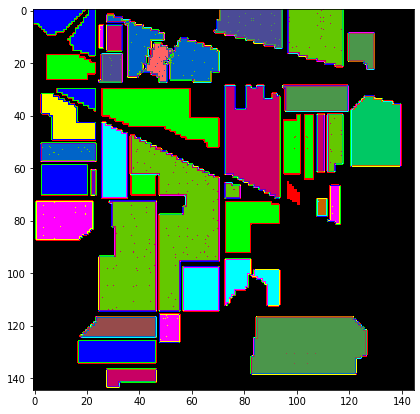

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

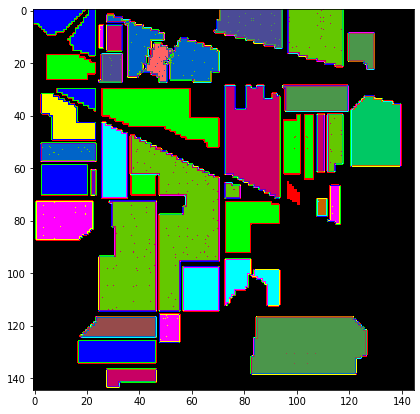

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)